# **0. Intro**

In [1]:
# to display all the outputs
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

from google.colab import drive
drive.mount('/content/drive')
import sys
nb_path = "/content/drive/My Drive/NeuralODE/Media"
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)

!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local jupyter
!python -m ipykernel install --name "py38" --user

!pip install git+https://github.com/DiffEqML/torchdyn.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2022-02-28 13:31:44--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M   135MB/s    in 0.6s    

2022-02-28 13:31:44 (135 MB/s) - ‘mini.sh’ saved [89817099/89817099]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::prompt-toolkit==3.0.20=pyhd3eb1b0_0
  - defaults/noarch::prometheus_client==

# **1. Libraries**

In [2]:
sys.path.append('/usr/local/lib/python3.8/site-packages/')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

import torch
import torch.utils.data as data

import torch.nn as nn
import pytorch_lightning as pl

import os

%load_ext autoreload
%autoreload 2
# quick run for automated notebook validation

# **2. Parameters**

In [3]:
# Parameters
dry_run = False
load_model = True
model_name = "/content/drive/MyDrive/NeuralODE/torch_models/MNIST_model.pt"

# **3. Import Dataset**

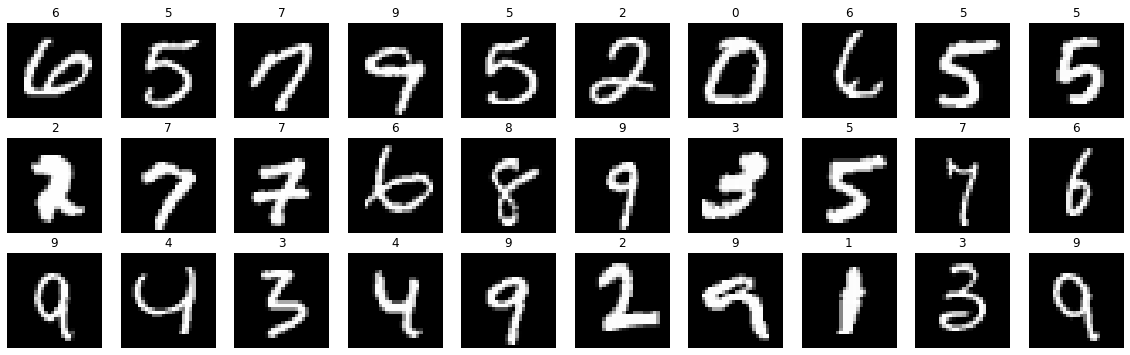

In [11]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data_train = np.genfromtxt('sample_data/mnist_train_small.csv', delimiter=',')
data_test  = np.genfromtxt('sample_data/mnist_test.csv', delimiter=',')

labels = data_train[:,0]
labels_test = data_test[:,0]

x_train = data_train[:,1:].transpose() / 255
x_test = data_test[:,1:].transpose() / 255

fig, axs = plt.subplots(ncols = 10, nrows = 3, figsize = (20,6));
axs = axs.reshape((-1,));
for i in range(30):
  image_i = x_train[:,i].reshape((28,28));
  axs[i].imshow(image_i, cmap='gray');
  axs[i].set_title(int(labels[i]));
  axs[i].axis('off');

y_train = data_train[:,0]
y_test = data_test[:,0]

# **4. Transform Dataset**

In [12]:
device = torch.device("cpu") # all of this works in GPU as well :)

XX_train = torch.Tensor(x_train.transpose()).to(device)
XX_test = torch.Tensor(x_test.transpose()).to(device)

YY_train = torch.LongTensor(y_train).to(device)
train = data.TensorDataset(XX_train, YY_train)
trainloader = data.DataLoader(train, batch_size=len(x_train.transpose()), shuffle=True)

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        #print('y_hat:')
        #print(y_hat)
        #print(y_hat.shape)
        #print('y:')
        #print(y)
        #print(y.shape)

        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader


def get_cifar_dloaders(batch_size=64, size=32, path='../data/cifar10_data', num_workers=20):
    batch_size=batch_size
    size=size
    path_to_data=path

    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_data = datasets.CIFAR10(path_to_data, train=True, download=True,
                                  transform=transform_train)
    test_data = datasets.CIFAR10(path_to_data, train=False,
                                 transform=transform_test)

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, testloader
    
    
class CIFARLearner(pl.LightningModule):
    def __init__(self, model:nn.Module, trainloader, testloader):
        super().__init__()
        self.model = model
        self.iters = 0.
        self.trainloader, self.testloader = trainloader, testloader
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1.
        x, y = batch   
        self.model[2].nfe = 0
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        epoch_progress = self.iters / self.loader_len
        acc = accuracy(y_hat, y)
        nfe = self.model[2].nfe ; self.model[2].nfe = 0
        tqdm_dict = {'train_loss': loss, 'accuracy': acc, 'NFE': nfe}
        return {'loss': loss, 'progress_bar': tqdm_dict}   

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        acc = accuracy(y_hat, y)
        return {'test_loss': nn.CrossEntropyLoss()(y_hat, y), 'test_accuracy': acc}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_accuracy'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss, 'avg_test_accuracy': avg_acc}
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=5e-4)
        sched = {'scheduler': torch.optim.lr_scheduler.StepLR(opt, 5, gamma=0.9),
                 'monitor': 'loss', 
                 'interval': 'epoch'}
        return [opt], [sched]

    def train_dataloader(self):
        self.loader_len = len(self.trainloader)
        return self.trainloader

    def test_dataloader(self):
        self.test_loader_len = len(self.testloader)
        return self.testloader

# **5. Training**

In [13]:
t_span = torch.linspace(0,1,5)

f = nn.Sequential(
        nn.Linear(784, 16),
        nn.Tanh(),
        nn.Linear(16, 784)
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)
learn = Learner(t_span, model)

if load_model:
  model.load_state_dict(torch.load(model_name))
else:
  if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
  else: trainer = pl.Trainer(min_epochs=40, max_epochs=100)
  trainer.fit(learn)
  print(learn)
  print("------")
  print(model)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [14]:
model

Neural ODE:
	- order: 1        
	- solver: RungeKutta4()
	- adjoint solver: DormandPrince45()        
	- tolerances: relative 0.001 absolute 0.001        
	- adjoint tolerances: relative 0.0001 absolute 0.0001        
	- num_parameters: 25888        
	- NFE: 0.0

# **6. Save**

In [ ]:
torch.save(model.state_dict(), model_name)

# **7. Trajectory**

## **7.1. Training**

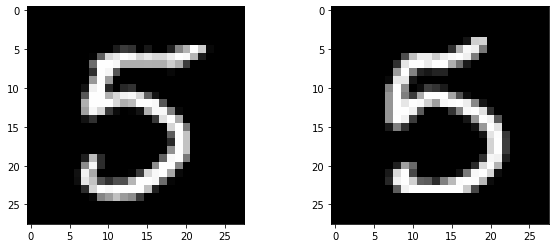

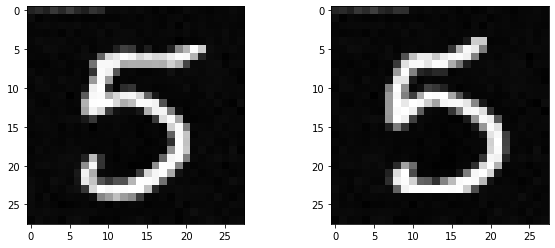

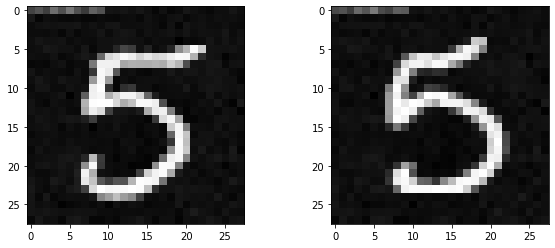

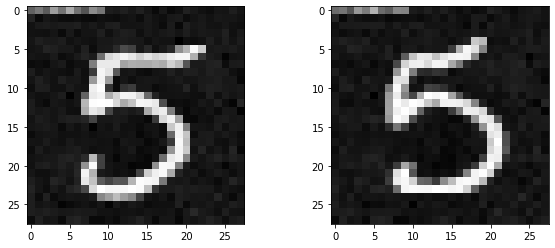

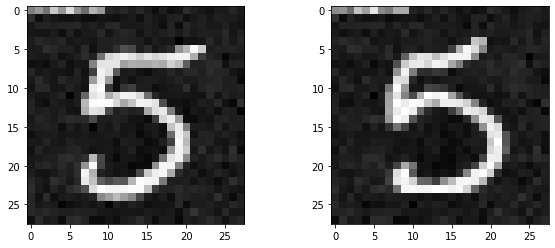

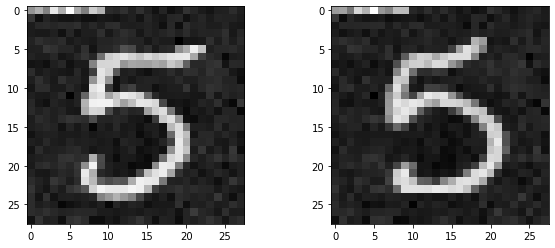

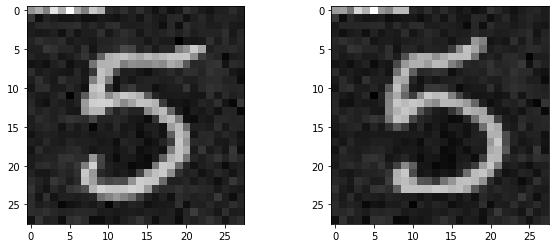

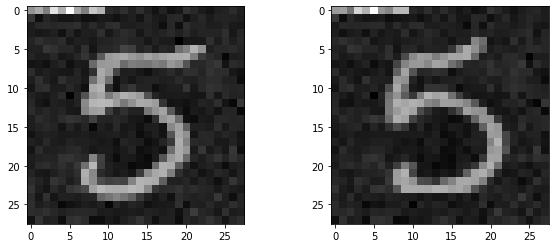

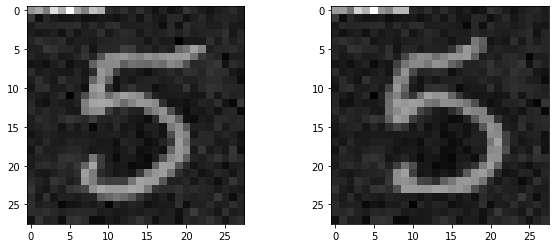

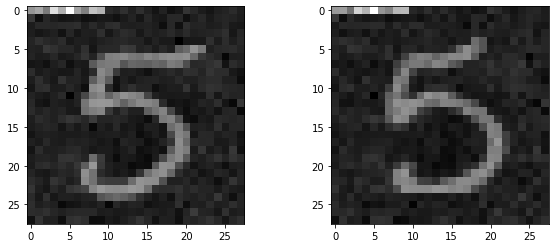

In [15]:
# Tentativo di plot
t_span_2 = torch.linspace(0,1,50)
t_eval, trajectory = model(XX_train, t_span_2)
trajectory = trajectory.detach().cpu()

i1=1
i2=4

for j in range(10):
  fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4))
  image_i1 = trajectory[j,i1,:].reshape((28,28))
  image_i2 = trajectory[j,i2,:].reshape((28,28))
  axs[0].imshow(image_i1, cmap='gray')
  axs[1].imshow(image_i2, cmap='gray')
  #axs[0].set_title(int(labels[0]))
  #axs[1].set_title(int(labesl[1]))
  #axs[0].axis('off')

In [9]:
A = XX_train
A_filtered = {}
indici = {}
for LAB in range(10):
  indici[LAB] = np.where(labels==LAB)

In [10]:
try:
  os.mkdir(os.path.join(nb_path, "MNIST_full"))
except Exception as e:
  print("Folder already exists")

ncolonne = 10
nrighe = 6

plt.ioff()
for j in range(50):
  fig, axs = plt.subplots(ncols = ncolonne, nrows = nrighe, figsize = (ncolonne*2,nrighe*2));
  axs = axs.reshape((-1,));
  for i in range(ncolonne):
    for n in range(nrighe):
      image = trajectory[j,indici[n][0][i],:].reshape((28,28))
      axs[i+ncolonne*n].imshow(image, cmap='gray');
      axs[i+ncolonne*n].axis('off');
    fig.savefig(os.path.join(nb_path, "MNIST_full", "MNIST_full_" + str(j)) , dpi=150)
    plt.close(fig)

Folder already exists


## **7.2. Test**

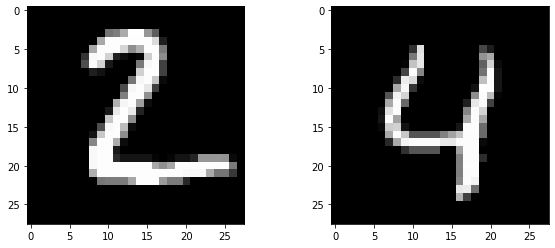

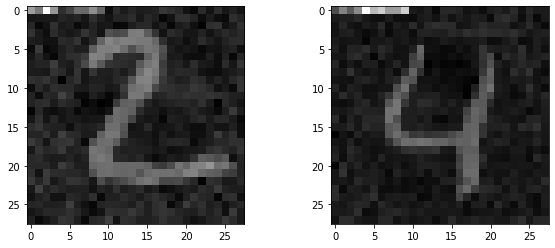

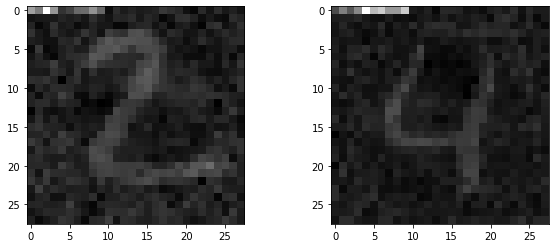

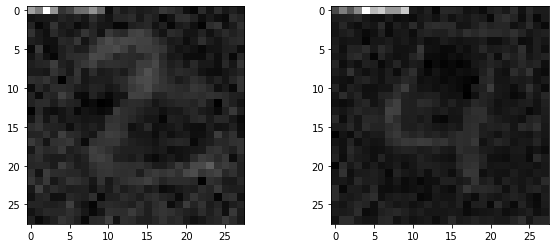

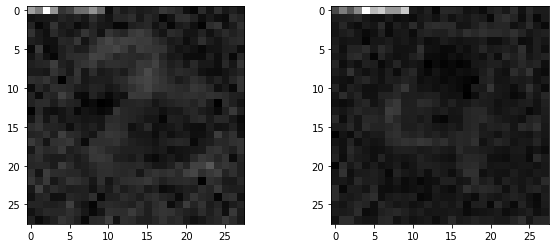

In [16]:
# Tentativo di plot
t_eval_test, trajectory_test = model(XX_test, t_span)
trajectory_test = trajectory_test.detach().cpu()

i1=1
i2=4

for j in range(5):
  fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4))
  image_i1 = trajectory_test[j,i1,:].reshape((28,28))
  image_i2 = trajectory_test[j,i2,:].reshape((28,28))
  axs[0].imshow(image_i1, cmap='gray')
  axs[1].imshow(image_i2, cmap='gray')
  #axs[0].set_title(int(labels[0]))
  #axs[1].set_title(int(labesl[1]))
  #axs[0].axis('off')

# **8. Accuracy**

In [17]:
accuracy_x_train = trajectory[-1,:,:]
accuracy_x_test  = trajectory_test[-1,:,:]

accuracy_x_train = accuracy_x_train.cpu().detach().numpy()
accuracy_x_test = accuracy_x_test.cpu().detach().numpy()

prob = tf.nn.softmax(accuracy_x_train[:, 0:10], axis=None, name=None)
prob_test = tf.nn.softmax(accuracy_x_test[:, 0:10], axis=None, name=None)

classification = np.argmax(prob, axis=1)
classification_test = np.argmax(prob_test, axis=1)

print(classification)
print(y_train)

accuracy = np.mean(classification == y_train)
accuracy_test = np.mean(classification_test == y_test)

print("Train Accuracy: ", accuracy)
print("Test Accuracy: ", accuracy_test)

[1 5 7 ... 2 9 5]
[6. 5. 7. ... 2. 9. 5.]
Train Accuracy:  0.87415
Test Accuracy:  0.8657


# **9. PCA**

## **9.1. PCA - Time independent**

In [ ]:
fig, axs=plt.subplots(nrows=1, ncols=5, figsize=(18,6))
axs=axs.reshape((-1,))
for j in range(5):
  A = trajectory[j,:,:]
  A = A.cpu().detach().numpy()
  A=A.transpose()
  labels=y_train
  A.shape
  A_mean=np.mean(A, axis=1)
  U, s, VT=np.linalg.svd(A-A_mean[:, None], full_matrices='False')
  Phi=np.matmul(U.transpose(), A-A_mean[:, None] )
  Phi.shape
  for i in range(10):
    axs[j].scatter(Phi[0, labels==i], Phi[1, labels==i], label=str(i))

## **9.2. PCA - Time dependent**

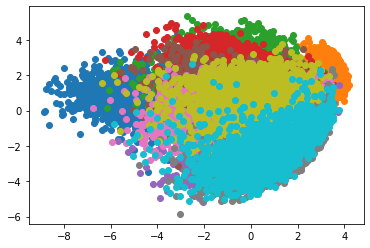

In [ ]:
j=0
A = trajectory[j,:,:]
A = A.cpu().detach().numpy()
A=A.transpose()
labels=y_train
#A.shape
A_mean=np.mean(A, axis=1)
U, s, VT=np.linalg.svd(A-A_mean[:, None], full_matrices='False')
Phi=np.matmul(U.transpose(), A-A_mean[:, None] )
#Phi.shape
for i in range(10):
  plt.scatter(Phi[0, labels==i], Phi[1, labels==i], label=str(i))

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

(784, 20000)

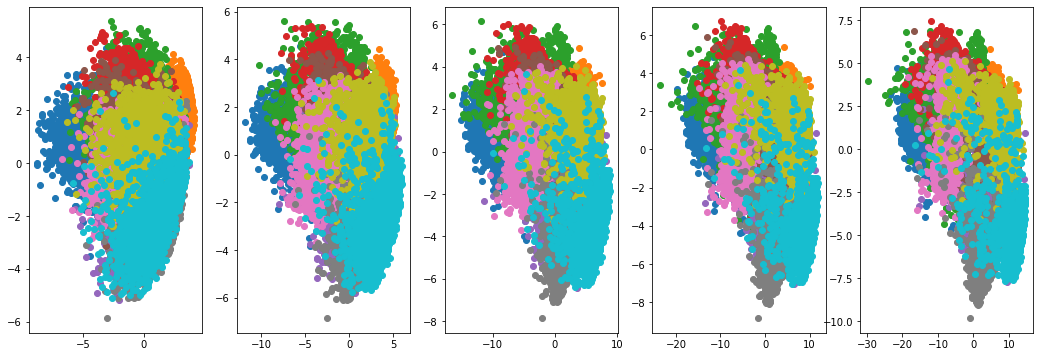

In [ ]:
fig, axs=plt.subplots(nrows=1, ncols=5, figsize=(18,6))
axs=axs.reshape((-1,))
for j in range(5):
  A = trajectory[j,:,:]
  A = A.cpu().detach().numpy()
  A=A.transpose()
  labels=y_train
  A.shape
  A_mean=np.mean(A, axis=1)
  Phi=np.matmul(U.transpose(), A-A_mean[:, None] )
  Phi.shape
  for i in range(10):
    axs[j].scatter(Phi[0, labels==i], Phi[1, labels==i], label=str(i))